# This notebook:
### plots beaching probability for the entire ocean with contours

In [1]:
# set working directory
import os
os.chdir('/dat1/openonic/Drifters') # directory

In [3]:
# dependencies
import pandas as pd
import scipy.interpolate as sci_int
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sci_stats
import cartopy.crs as ccrs
import geopandas as gpd

import matplotlib.colors as mcolors


In [4]:
# import undrogued data
beach = pd.read_csv('undrogued_beach.csv')
unbeach = pd.read_csv('undrogued_unbeach.csv')

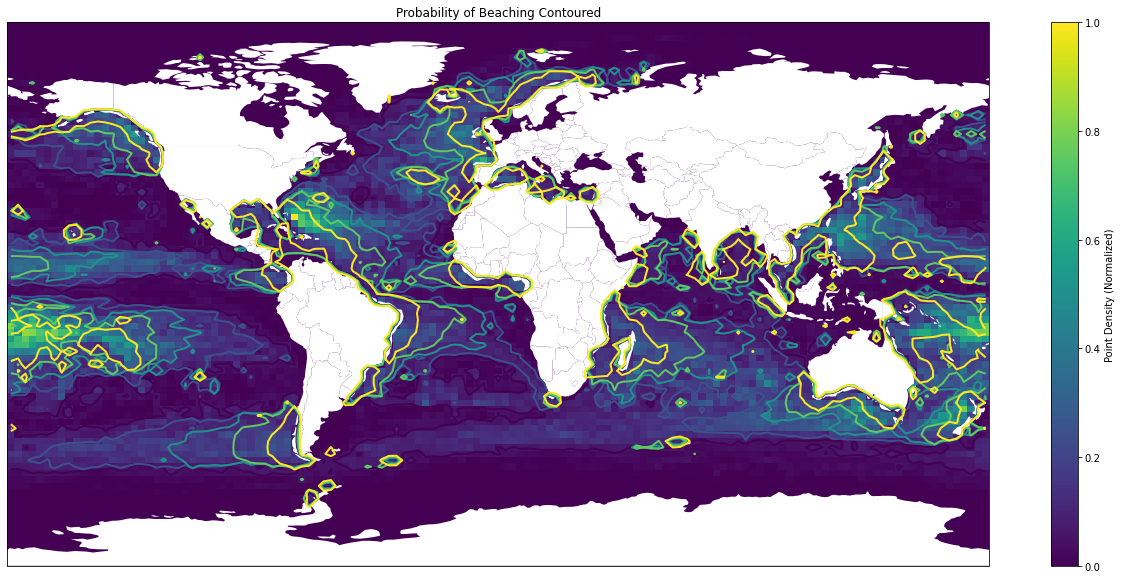

In [5]:
# Define dataframe used:
df_used = beach

# Define the grid for the heatmap
n_lons, n_lats = 135, 85  # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

# Initialize mesh
heatmap_data_normalized = np.zeros((n_lats, n_lons))

latitudes = []
longitudes = []
latitudes12 = []
longitudes12 = []
latitudes6 = []
longitudes6 = []
latitudes3 = []
longitudes3 = []
latitudes1 = []
longitudes1 = []

for ID in np.unique(df_used['id']):
    trajectory = df_used[df_used['id'] == ID]

    latest_time = max(trajectory['time'])
    start_time = latest_time - 15552000000000  # Full
    start_time12 = latest_time - 31536000  # 12m
    start_time6 = latest_time - 15552000  # 6m
    start_time3 = latest_time - 7890000  # 3m
    start_time1 = latest_time - 2629800  # 1m

    latest_data_all = trajectory[trajectory['time'] <= latest_time]

    latest_data = latest_data_all[latest_data_all['time'] >= start_time]
    latest_data12 = latest_data_all[latest_data_all['time'] >= start_time12]
    latest_data6 = latest_data_all[latest_data_all['time'] >= start_time6]
    latest_data3 = latest_data_all[latest_data_all['time'] >= start_time3]
    latest_data1 = latest_data_all[latest_data_all['time'] >= start_time1]

    latitudes += list(latest_data['lat'])
    longitudes += list(latest_data['lon'])

    latitudes12 += list(latest_data12['lat'])
    longitudes12 += list(latest_data12['lon'])

    latitudes6 += list(latest_data6['lat'])
    longitudes6 += list(latest_data6['lon'])

    latitudes3 += list(latest_data3['lat'])
    longitudes3 += list(latest_data3['lon'])

    latitudes1 += list(latest_data1['lat'])
    longitudes1 += list(latest_data1['lon'])

# Calculate the 2D histogram (density plot) of point density
heatmap_data, _, _ = np.histogram2d(latitudes, longitudes, bins=[lat_bins, lon_bins], density=True)

# Normalize the data to be in the range [0, 1]
heatmap_data_normalized_cluster = (heatmap_data - np.min(heatmap_data)) / (np.max(heatmap_data) - np.min(heatmap_data))

lon_centers_cluster = (lon_bins[1:] + lon_bins[:-1]) / 2
lat_centers_cluster = (lat_bins[1:] + lat_bins[:-1]) / 2

# Append to previous clusters
heatmap_data_normalized += (heatmap_data - np.min(heatmap_data)) / (np.max(heatmap_data) - np.min(heatmap_data))

# Calculate the 2D histogram (density plot) of point density for 12m
heatmap_data12, _, _ = np.histogram2d(latitudes12, longitudes12, bins=[lat_bins, lon_bins], density=True)
heatmap_data_normalized12 = (heatmap_data12 - np.min(heatmap_data12)) / (np.max(heatmap_data12) - np.min(heatmap_data12))

# Calculate the 2D histogram (density plot) of point density for 6m
heatmap_data6, _, _ = np.histogram2d(latitudes6, longitudes6, bins=[lat_bins, lon_bins], density=True)
heatmap_data_normalized6 = (heatmap_data6 - np.min(heatmap_data6)) / (np.max(heatmap_data6) - np.min(heatmap_data6))

# Calculate the 2D histogram (density plot) of point density for 3m
heatmap_data3, _, _ = np.histogram2d(latitudes3, longitudes3, bins=[lat_bins, lon_bins], density=True)
heatmap_data_normalized3 = (heatmap_data3 - np.min(heatmap_data3)) / (np.max(heatmap_data3) - np.min(heatmap_data3))

# Calculate the 2D histogram (density plot) of point density for 1m
heatmap_data1, _, _ = np.histogram2d(latitudes1, longitudes1, bins=[lat_bins, lon_bins], density=True)
heatmap_data_normalized1 = (heatmap_data1 - np.min(heatmap_data1)) / (np.max(heatmap_data1) - np.min(heatmap_data1))

fig = plt.figure(figsize=(22, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# Load the world shapefile from GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Extract the land polygons
land = world[world['continent'] != 'Antarctica']
Antarctica = world[world['continent'] == 'Antarctica']

# Define the number of contours
num_contours = 5

# Generate a sequence of colors with increasing intensity from a colormap
colors = plt.cm.viridis(np.linspace(0, 1, num_contours))

# Plot contours with specified colors
for data_normalized, color in zip([heatmap_data_normalized_cluster, heatmap_data_normalized12,
                                   heatmap_data_normalized6, heatmap_data_normalized3,
                                   heatmap_data_normalized1], colors):
    # Add contour lines at the specified level (0.05 in this case)
    contour = plt.contour(lon_centers_cluster, lat_centers_cluster, data_normalized,
                          levels=[0.05], colors=[color], linestyles='solid', linewidths=2,
                          transform=ccrs.PlateCarree())

# Plot the filled contour for normalized heatmap
mesh = ax.pcolormesh(lon_centers_cluster, lat_centers_cluster, heatmap_data_normalized,
                     cmap=plt.cm.get_cmap("viridis"), transform=ccrs.PlateCarree())

# Plot the land polygons with white face color, no edge
land.plot(ax=ax, color='white', edgecolor='none')
Antarctica.plot(ax=ax, color='white', edgecolor='none')

plt.colorbar(mesh, label='Point Density (Normalized)')
ax.set_aspect('auto')
plt.title('Probability of Beaching Contoured')

plt.show()

## Let's do this again but with two temporal subsets of the original dataset

Text(0, 0.5, 'count')

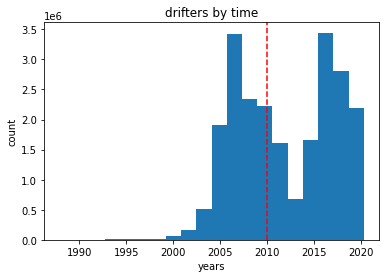

In [6]:
plt.hist(1970 + beach['time'] / 60 / 60 / 24 / 365, bins = 20)
plt.axvline(x=2010, color='red', linestyle='--')
plt.title('drifters by time')
plt.xlabel('years')
plt.ylabel('count')

### Unfortunately, we can't simply take the first 16 or so years of data because there is so little. Let's consider all data before 2010 as 'old' and all data after 2010 as 'new.' This will result in analysis of change from before and after 2010 while allowing for a sizeable amount of data for both 'old' and 'new'

In [7]:
# let's make two subsets of the original dataset, splitting them into equal halves
split_by = (2010 - 1970) * 60 * 60 * 24 * 365

traj_end = beach.drop_duplicates(subset='id', keep='last') # will split by whether their last point is greater than 2004 or not
beach_new_traj = traj_end[traj_end['time'] > split_by]
beach_old_traj = traj_end[traj_end['time'] <= split_by]

# get all points in traj
# Get unique IDs from beach_new_traj and beach_old_traj
ids_to_filter = beach_new_traj['id'].tolist() + beach_old_traj['id'].tolist()

# Filter beach DataFrame for the unique IDs
beach_filtered = beach[beach['id'].isin(ids_to_filter)]

# Separate filtered data into beach_new and beach_old based on IDs
beach_new = beach_filtered[beach_filtered['id'].isin(beach_new_traj['id'])]
beach_old = beach_filtered[beach_filtered['id'].isin(beach_old_traj['id'])]

## Let's explore beaching trends before 2010

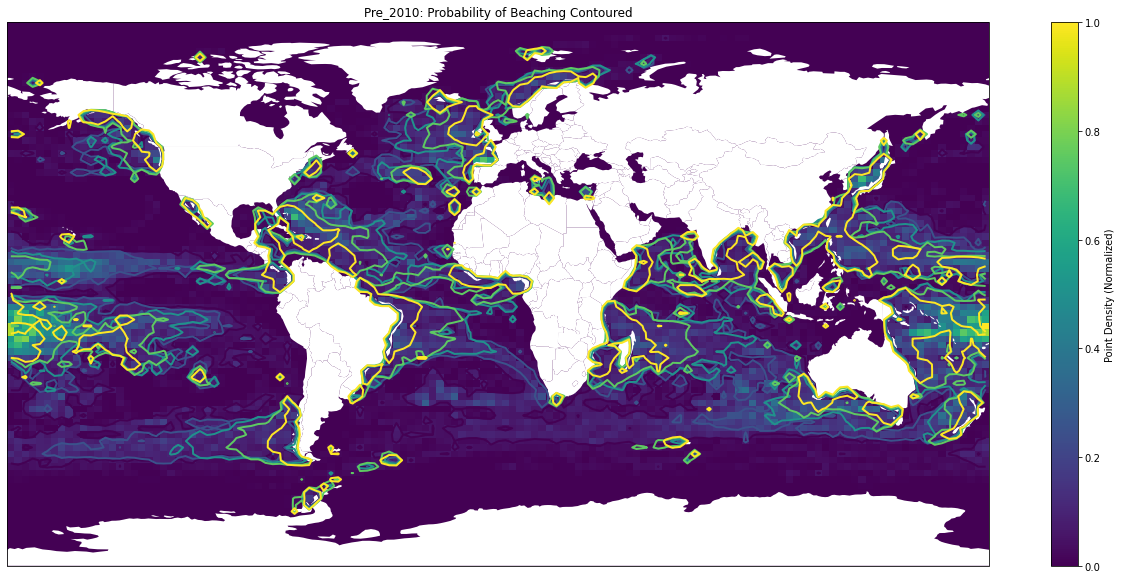

In [8]:
# Define dataframe used:
df_used = beach_old

# Define the grid for the heatmap
n_lons, n_lats = 135, 85  # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

# Initialize mesh
heatmap_data_normalized = np.zeros((n_lats, n_lons))

latitudes = []
longitudes = []
latitudes12 = []
longitudes12 = []
latitudes6 = []
longitudes6 = []
latitudes3 = []
longitudes3 = []
latitudes1 = []
longitudes1 = []

for ID in np.unique(df_used['id']):
    trajectory = df_used[df_used['id'] == ID]

    latest_time = max(trajectory['time'])
    start_time = latest_time - 15552000000000  # Full
    start_time12 = latest_time - 31536000  # 12m
    start_time6 = latest_time - 15552000  # 6m
    start_time3 = latest_time - 7890000  # 3m
    start_time1 = latest_time - 2629800  # 1m

    latest_data_all = trajectory[trajectory['time'] <= latest_time]

    latest_data = latest_data_all[latest_data_all['time'] >= start_time]
    latest_data12 = latest_data_all[latest_data_all['time'] >= start_time12]
    latest_data6 = latest_data_all[latest_data_all['time'] >= start_time6]
    latest_data3 = latest_data_all[latest_data_all['time'] >= start_time3]
    latest_data1 = latest_data_all[latest_data_all['time'] >= start_time1]

    latitudes += list(latest_data['lat'])
    longitudes += list(latest_data['lon'])

    latitudes12 += list(latest_data12['lat'])
    longitudes12 += list(latest_data12['lon'])

    latitudes6 += list(latest_data6['lat'])
    longitudes6 += list(latest_data6['lon'])

    latitudes3 += list(latest_data3['lat'])
    longitudes3 += list(latest_data3['lon'])

    latitudes1 += list(latest_data1['lat'])
    longitudes1 += list(latest_data1['lon'])

# Calculate the 2D histogram (density plot) of point density
heatmap_data, _, _ = np.histogram2d(latitudes, longitudes, bins=[lat_bins, lon_bins], density=True)

# Normalize the data to be in the range [0, 1]
heatmap_data_normalized_cluster = (heatmap_data - np.min(heatmap_data)) / (np.max(heatmap_data) - np.min(heatmap_data))

lon_centers_cluster = (lon_bins[1:] + lon_bins[:-1]) / 2
lat_centers_cluster = (lat_bins[1:] + lat_bins[:-1]) / 2

# Append to previous clusters
heatmap_data_normalized += (heatmap_data - np.min(heatmap_data)) / (np.max(heatmap_data) - np.min(heatmap_data))

# Calculate the 2D histogram (density plot) of point density for 12m
heatmap_data12, _, _ = np.histogram2d(latitudes12, longitudes12, bins=[lat_bins, lon_bins], density=True)
heatmap_data_normalized12 = (heatmap_data12 - np.min(heatmap_data12)) / (np.max(heatmap_data12) - np.min(heatmap_data12))

# Calculate the 2D histogram (density plot) of point density for 6m
heatmap_data6, _, _ = np.histogram2d(latitudes6, longitudes6, bins=[lat_bins, lon_bins], density=True)
heatmap_data_normalized6 = (heatmap_data6 - np.min(heatmap_data6)) / (np.max(heatmap_data6) - np.min(heatmap_data6))

# Calculate the 2D histogram (density plot) of point density for 3m
heatmap_data3, _, _ = np.histogram2d(latitudes3, longitudes3, bins=[lat_bins, lon_bins], density=True)
heatmap_data_normalized3 = (heatmap_data3 - np.min(heatmap_data3)) / (np.max(heatmap_data3) - np.min(heatmap_data3))

# Calculate the 2D histogram (density plot) of point density for 1m
heatmap_data1, _, _ = np.histogram2d(latitudes1, longitudes1, bins=[lat_bins, lon_bins], density=True)
heatmap_data_normalized1 = (heatmap_data1 - np.min(heatmap_data1)) / (np.max(heatmap_data1) - np.min(heatmap_data1))

fig = plt.figure(figsize=(22, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# Load the world shapefile from GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Extract the land polygons
land = world[world['continent'] != 'Antarctica']
Antarctica = world[world['continent'] == 'Antarctica']

# Define the number of contours
num_contours = 5

# Generate a sequence of colors with increasing intensity from a colormap
colors = plt.cm.viridis(np.linspace(0, 1, num_contours))

# Plot contours with specified colors
for data_normalized, color in zip([heatmap_data_normalized_cluster, heatmap_data_normalized12,
                                   heatmap_data_normalized6, heatmap_data_normalized3,
                                   heatmap_data_normalized1], colors):
    # Add contour lines at the specified level (0.05 in this case)
    contour = plt.contour(lon_centers_cluster, lat_centers_cluster, data_normalized,
                          levels=[0.05], colors=[color], linestyles='solid', linewidths=2,
                          transform=ccrs.PlateCarree())

# Plot the filled contour for normalized heatmap
mesh = ax.pcolormesh(lon_centers_cluster, lat_centers_cluster, heatmap_data_normalized,
                     cmap=plt.cm.get_cmap("viridis"), transform=ccrs.PlateCarree())

# Plot the land polygons with white face color, no edge
land.plot(ax=ax, color='white', edgecolor='none')
Antarctica.plot(ax=ax, color='white', edgecolor='none')

plt.colorbar(mesh, label='Point Density (Normalized)')
ax.set_aspect('auto')
plt.title('Pre_2010: Probability of Beaching Contoured')

plt.show()

## Now, let's see how this changes after 2010

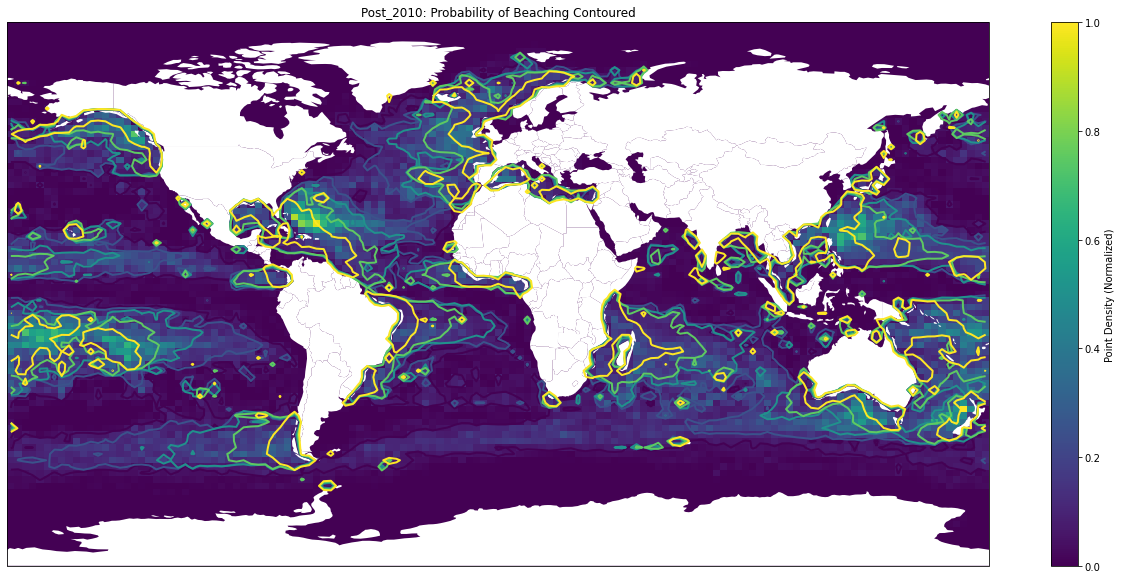

In [9]:
# Define dataframe used:
df_used = beach_new

# Define the grid for the heatmap
n_lons, n_lats = 135, 85  # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

# Initialize mesh
heatmap_data_normalized = np.zeros((n_lats, n_lons))

latitudes = []
longitudes = []
latitudes12 = []
longitudes12 = []
latitudes6 = []
longitudes6 = []
latitudes3 = []
longitudes3 = []
latitudes1 = []
longitudes1 = []

for ID in np.unique(df_used['id']):
    trajectory = df_used[df_used['id'] == ID]

    latest_time = max(trajectory['time'])
    start_time = latest_time - 15552000000000  # Full
    start_time12 = latest_time - 31536000  # 12m
    start_time6 = latest_time - 15552000  # 6m
    start_time3 = latest_time - 7890000  # 3m
    start_time1 = latest_time - 2629800  # 1m

    latest_data_all = trajectory[trajectory['time'] <= latest_time]

    latest_data = latest_data_all[latest_data_all['time'] >= start_time]
    latest_data12 = latest_data_all[latest_data_all['time'] >= start_time12]
    latest_data6 = latest_data_all[latest_data_all['time'] >= start_time6]
    latest_data3 = latest_data_all[latest_data_all['time'] >= start_time3]
    latest_data1 = latest_data_all[latest_data_all['time'] >= start_time1]

    latitudes += list(latest_data['lat'])
    longitudes += list(latest_data['lon'])

    latitudes12 += list(latest_data12['lat'])
    longitudes12 += list(latest_data12['lon'])

    latitudes6 += list(latest_data6['lat'])
    longitudes6 += list(latest_data6['lon'])

    latitudes3 += list(latest_data3['lat'])
    longitudes3 += list(latest_data3['lon'])

    latitudes1 += list(latest_data1['lat'])
    longitudes1 += list(latest_data1['lon'])

# Calculate the 2D histogram (density plot) of point density
heatmap_data, _, _ = np.histogram2d(latitudes, longitudes, bins=[lat_bins, lon_bins], density=True)

# Normalize the data to be in the range [0, 1]
heatmap_data_normalized_cluster = (heatmap_data - np.min(heatmap_data)) / (np.max(heatmap_data) - np.min(heatmap_data))

lon_centers_cluster = (lon_bins[1:] + lon_bins[:-1]) / 2
lat_centers_cluster = (lat_bins[1:] + lat_bins[:-1]) / 2

# Append to previous clusters
heatmap_data_normalized += (heatmap_data - np.min(heatmap_data)) / (np.max(heatmap_data) - np.min(heatmap_data))

# Calculate the 2D histogram (density plot) of point density for 12m
heatmap_data12, _, _ = np.histogram2d(latitudes12, longitudes12, bins=[lat_bins, lon_bins], density=True)
heatmap_data_normalized12 = (heatmap_data12 - np.min(heatmap_data12)) / (np.max(heatmap_data12) - np.min(heatmap_data12))

# Calculate the 2D histogram (density plot) of point density for 6m
heatmap_data6, _, _ = np.histogram2d(latitudes6, longitudes6, bins=[lat_bins, lon_bins], density=True)
heatmap_data_normalized6 = (heatmap_data6 - np.min(heatmap_data6)) / (np.max(heatmap_data6) - np.min(heatmap_data6))

# Calculate the 2D histogram (density plot) of point density for 3m
heatmap_data3, _, _ = np.histogram2d(latitudes3, longitudes3, bins=[lat_bins, lon_bins], density=True)
heatmap_data_normalized3 = (heatmap_data3 - np.min(heatmap_data3)) / (np.max(heatmap_data3) - np.min(heatmap_data3))

# Calculate the 2D histogram (density plot) of point density for 1m
heatmap_data1, _, _ = np.histogram2d(latitudes1, longitudes1, bins=[lat_bins, lon_bins], density=True)
heatmap_data_normalized1 = (heatmap_data1 - np.min(heatmap_data1)) / (np.max(heatmap_data1) - np.min(heatmap_data1))

fig = plt.figure(figsize=(22, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# Load the world shapefile from GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Extract the land polygons
land = world[world['continent'] != 'Antarctica']
Antarctica = world[world['continent'] == 'Antarctica']

# Define the number of contours
num_contours = 5

# Generate a sequence of colors with increasing intensity from a colormap
colors = plt.cm.viridis(np.linspace(0, 1, num_contours))

# Plot contours with specified colors
for data_normalized, color in zip([heatmap_data_normalized_cluster, heatmap_data_normalized12,
                                   heatmap_data_normalized6, heatmap_data_normalized3,
                                   heatmap_data_normalized1], colors):
    # Add contour lines at the specified level (0.05 in this case)
    contour = plt.contour(lon_centers_cluster, lat_centers_cluster, data_normalized,
                          levels=[0.05], colors=[color], linestyles='solid', linewidths=2,
                          transform=ccrs.PlateCarree())

# Plot the filled contour for normalized heatmap
mesh = ax.pcolormesh(lon_centers_cluster, lat_centers_cluster, heatmap_data_normalized,
                     cmap=plt.cm.get_cmap("viridis"), transform=ccrs.PlateCarree())

# Plot the land polygons with white face color, no edge
land.plot(ax=ax, color='white', edgecolor='none')
Antarctica.plot(ax=ax, color='white', edgecolor='none')

plt.colorbar(mesh, label='Point Density (Normalized)')
ax.set_aspect('auto')
plt.title('Post_2010: Probability of Beaching Contoured')

plt.show()